# Tutorial on Multi-Head Attention and Transformers

by Mark Mazumder (https://markmaz.com), for the [Harvard Edge Lab's](https://edge.seas.harvard.edu/) LLM Reading Group

[Launch this notebook in Google Colab](https://colab.research.google.com/github/mmaz/transformer_tutorial/blob/main/transformer_tutorial.ipynb)

This tutorial covers an implementation of the core pieces of a transformer.

First, as a refresher, these are the key diagrams from the classic paper [Attention is All You Need](https://arxiv.org/abs/1706.03762).  

Let's understand what $Q, K, V$ are, and what each of these operations do at the code level.

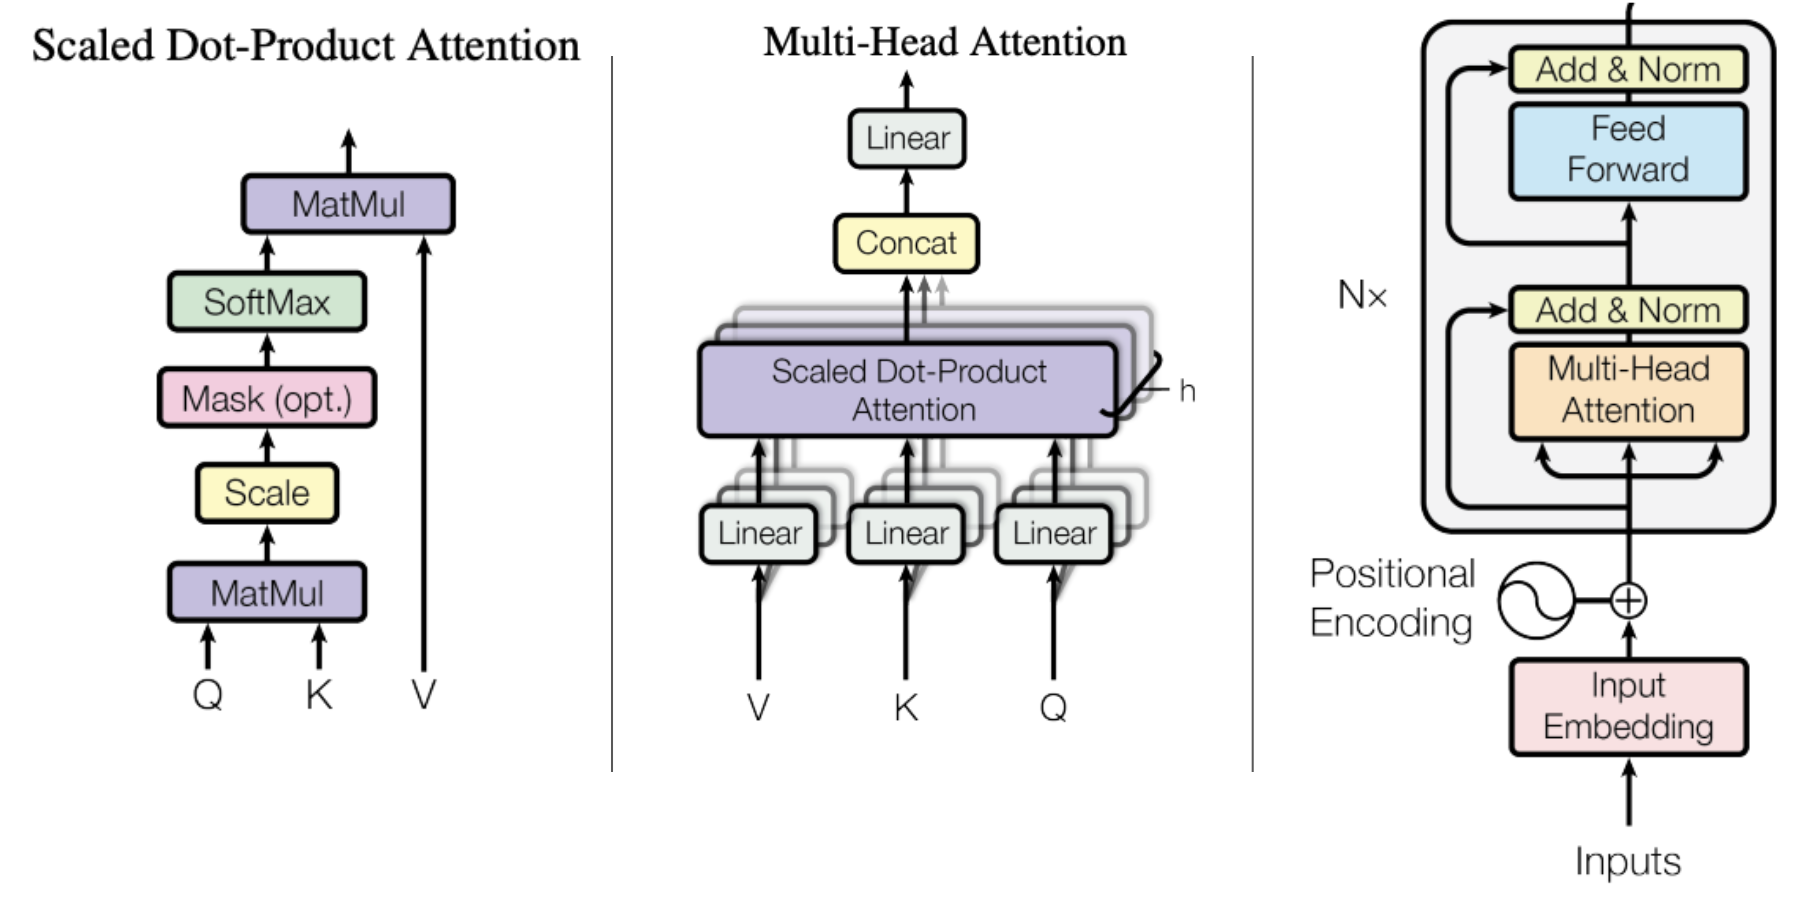

This is a pytorch implementation of multi-head attention taken from [HuggingFace & PyTorch Image Models](https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py)

```python
class Attention(nn.Module):
    def __init__(
            self,
            dim,
            num_heads=8,
            qkv_bias=False,
            qk_norm=False,
            attn_drop=0.,
            proj_drop=0.,
            norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.q_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.k_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        q, k = self.q_norm(q), self.k_norm(k)

        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return
```


Let's break down each step and inspect the input and output dimensions.

`num_heads` is the number of attention heads. Let's set `num_heads=8` and work through a concrete example.

`head_dim` is the dimension of each head. Let's set our model's embedding dimension to `512`. Then

```python
head_dim = 64 # dim // num_heads, i.e., 512/8
```

Attention is defined in the 2017 paper as the following:

$$
\mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

$Q, K, V$ are *queries, keys,* and *values* produced via self-attention on an input $x$.

$x$ is (possibly a batch of) a sequence of *tokens*, where each token represents a sentencepiece (for text) or patch (for an image).

Naturally, we see the input `x` in the first two lines of `forward`:

```python
def forward(self, x):
       B, N, C = x.shape
```

For our concrete example, let us assume

* Batch `B = 10`
* Sequence length `N = 37` as the number of input tokens (we will see why we chose this number later)
* "Channels" (the model's embedding dimension) `C = 512`

Before we delve into $Q, K, V$, let us look at the `scale` parameter, since it is a simple scalar.

`scale` is the amount we scale the dot products for attention by, namely $\sqrt{d_k}$ in the above equation. See footnote 4 in the original paper:

> We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients. To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$.  Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$.


Here, we scale by each head's dimensions rather than the model's embedding dimension, i.e.,

```python
self.scale = 0.125 # head_dim=64 ** -0.5
```

Now let's dive into the details of queries, keys, and values:


Here is a pictorial representation of attention and multi-head attention taken from http://lucasb.eyer.be/transformer [[slides](https://docs.google.com/presentation/d/1ZXFIhYczos679r70Yu8vV9uO6B1J0ztzeDxbnBxD1S0/edit#slide=id.g13dd67c5ab8_0_79)] by Lucas Beyer. He also has several talks on youtube going through these slides.

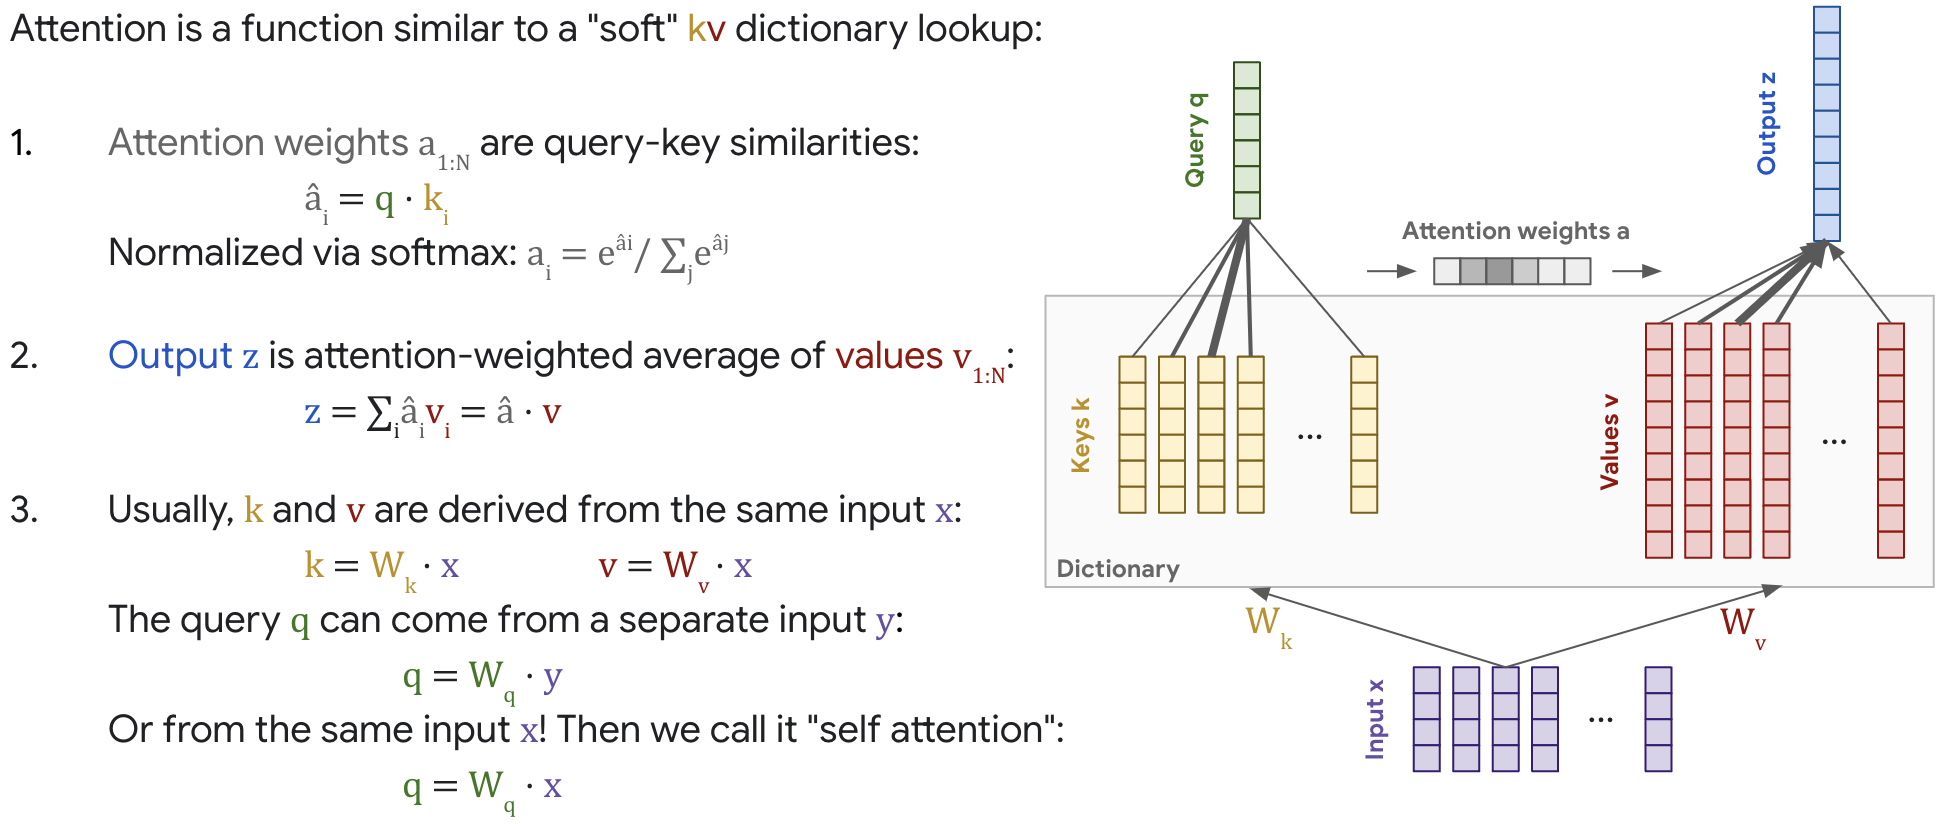

A single query $q$ is a vector of dimension $d_{\text{embedding}}=512$. We will see how $q$ is computed from $x$ shortly.

Keys are each vectors of dimension $d_{\text{embedding}}=512$ (and we will have  $d_{\text{seqlen}}=37$ of them in total).

Attention computes the similarity of each query to each key, while values are the returned items from the soft dictionary (weighted by attention)

Keys are computed from $W_k$ and $x$, as shown above. $W_k$ is a matrix of dimension $d_{\text{embedding}} \times d_{\text{embedding}}$= 512x512

In the above implementation, $W_q, W_k, W_v$ are all defined as one linear projection for efficiency using

`torch.nn.Linear(in_features, out_features, bias: bool)`:

```python
self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
```

> Aside: the notation from Lucas Beyer's slide is slightly different from the 2017 paper's notation. These are the same projection matrices $W^Q, W^K, W^V$, in the 2017 paper, where `qkv` $\in \mathbb{R}^{d_{\text{model}} \times 3 \cdot {d_{\text{model}}}}$

Note that [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is defined as $y = xA^T + b$, thus

* with `x` of shape `(37,512)`
* with $W_k$ of shape `(512,512)`
* for simplicity, assume `bias=False`

So, $K = xW_k^T$, a matrix of shape `(37,512)`

The attention vector shown above is the dot product of $q$ with each key in $K$, resulting in a vector of dimension $d=37$:

In [ ]:
import torch
K = torch.rand(37,512)
q = torch.rand(512)
(q @ K.T).shape
# torch.Size([37])

Instead of using a single query, implementations use multiple queries. This forms an attention matrix instead of an attention vector.

Standard implementations perform $d_{\text{seqlen}}$ queries, resulting in an output attention matrix of $d_{\text{seqlen}} \times d_{\text{seqlen}}$

$W_q$ is a matrix of dimension $d_{\text{embedding}} \times d_{\text{embedding}}$= 512x512 and since we are computing <u>self-attention</u> we use the same input $x$ to compute

$Q = xW_q^T$

And as above, we will have an output matrix $Q$ of shape `(37,512)`

Finally, $W_v$ is *also* a matrix of `(512x512)` and the values $V$ are calculated just as with $Q$ and $K$, namely:

$V = xW_v^T$, of shape `(37,512)`

Now we can see how attention is computed quite straightforwardly, as

$$
\mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$


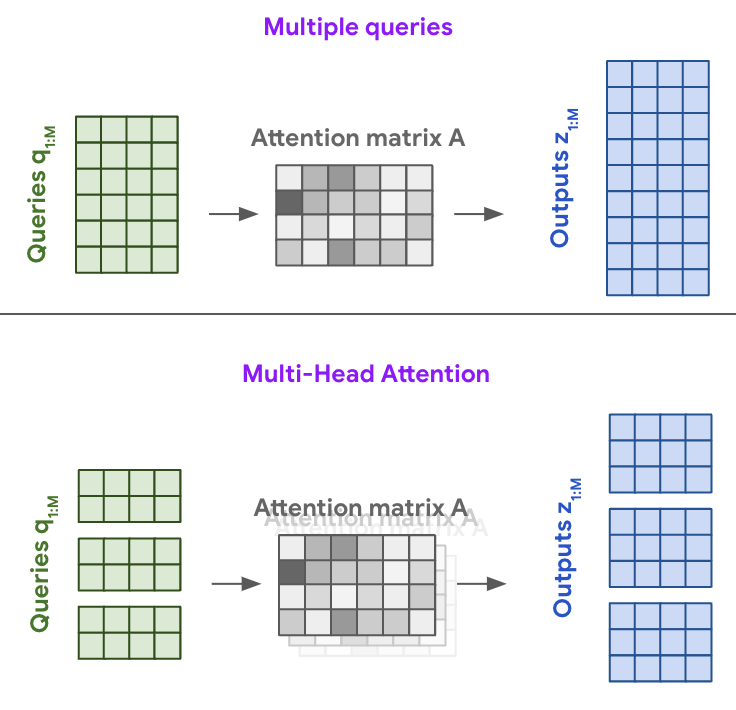

MultiHead attention is defined as:

$$
\begin{align*}
    \mathrm{MultiHead}(Q, K, V) &= \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O\\
%    \mathrm{where} \mathrm{head_i} &= \mathrm{Attention}(QW_Q_i^{\dmodel \times d_q}, KW_K_i^{\dmodel \times d_k}, VW^V_i^{\dmodel \times d_v})\\
    \text{where}~\mathrm{head_i} &= \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)\\
\end{align*}
$$

Where the projections are parameter matrices

$W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$,

$W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$,

$W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$

and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.

Recall our projection matrix `qkv`:

```python
self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
```

Multi-head attention is therefore very simple, we just partition this big projection matrix into `num_heads` slices and proceed with standard attention computation on each slice as above, and concatenate the results. (We will cover the final projection matrix $W^O$ shortly). Let's see it in code (skipping dropout and normalization for simplicity):

In [ ]:
!pip install --quiet einops

In [ ]:
import torch
import torch.nn as nn
import einops

dim = 512
batch_size = 10
num_tokens = 37
num_heads = 8
head_dim = dim // num_heads

# the core elements of multi-head attention:

qkv = nn.Linear(dim, 3*dim)
x = torch.rand(batch_size, num_tokens,dim)

B, N, C = x.shape

# we can make the following line more readable using einstein operations (for a full tutorial see https://einops.rocks/1-einops-basics/)

# qkv = qkv(x).reshape(B, N, 3, num_heads, head_dim).permute(2, 0, 3, 1, 4)

# note: the 3 in (B,N,3,...) simply comes from q,k,v

qkv = qkv(x)
print("initial projection", qkv.shape)
# for each batch and for each token, a projection to a 1536-dim vector
# torch.Size([10, 37, 1536])

qkv = qkv.reshape(B, N, 3, num_heads, head_dim)
print("multihead reshape", qkv.shape)
# (batch, token, qkv, num_heads, head_dim)
# torch.Size([10, 37, 3, 8, 64])
qkv = einops.rearrange(qkv, 'batch num_tokens qkv num_heads head_dim -> qkv batch num_heads num_tokens head_dim')
print("qkv permutation", qkv.shape)
# torch.Size([3, 10, 8, 37, 64])
q, k, v = qkv.unbind(0)
# for each q,k,v, for each batch, for each head, a matrix of d_seq x d_head
# these are our Q_i, K_i, V_i per head!
# torch.Size([10, 8, 37, 64])

attn = q @ k.transpose(-2, -1)
attn = attn.softmax(dim=-1)
print("multihead attention", attn.shape)
# torch.Size([10, 8, 37, 37])
x = attn @ v
print("multihead output", x.shape)
# torch.Size([10, 8, 37, 64])

x = x.transpose(1, 2).reshape(B, N, C)
print("output", x.shape)
# torch.Size([10, 37, 512])

We know that attention operates as a softmax over the product of $QK^T$. Looking at the dimensions above, it's now clear why k is transposed like this:

```python
attn = q @ k.transpose(-2, -1)
```

* `q` and `k` are each `(batch, head, d_seq, d_head)`
    * in our example, `10,8,37,64`
* `k.transpose(-2, -1)` flips `k` to `(batch, head, d_head, d_seq)` to enable matrix multiplication. In other words, for each head,
    * $Q_i$: `(d_seq, d_head)`
    * $K_i^T$: `(d_head, d_seq)`
* now the shapes are compatible, producing an output of `(batch, head, d_seq, d_seq)`

The only part we have yet to cover in the Multi-Head Attention diagram (middle) is the final linear projection on the concatenated output, i.e., $W^O$ in the original paper.

```python
self.proj = nn.Linear(dim, dim) # e.g., 512x512
...
x = x.transpose(1, 2).reshape(B, N, C)
x = self.proj(x)
```

This projection is applied independently to each token, so the output shape is unchanged (still $B,N,C$)

That concludes our walkthrough of multi-head attention!

# Transformers

Finally, let's look at each transformer block (right), and note the additional operations that consist of a transformer implementation

* feed-forward network
* residual connections
* layernorm


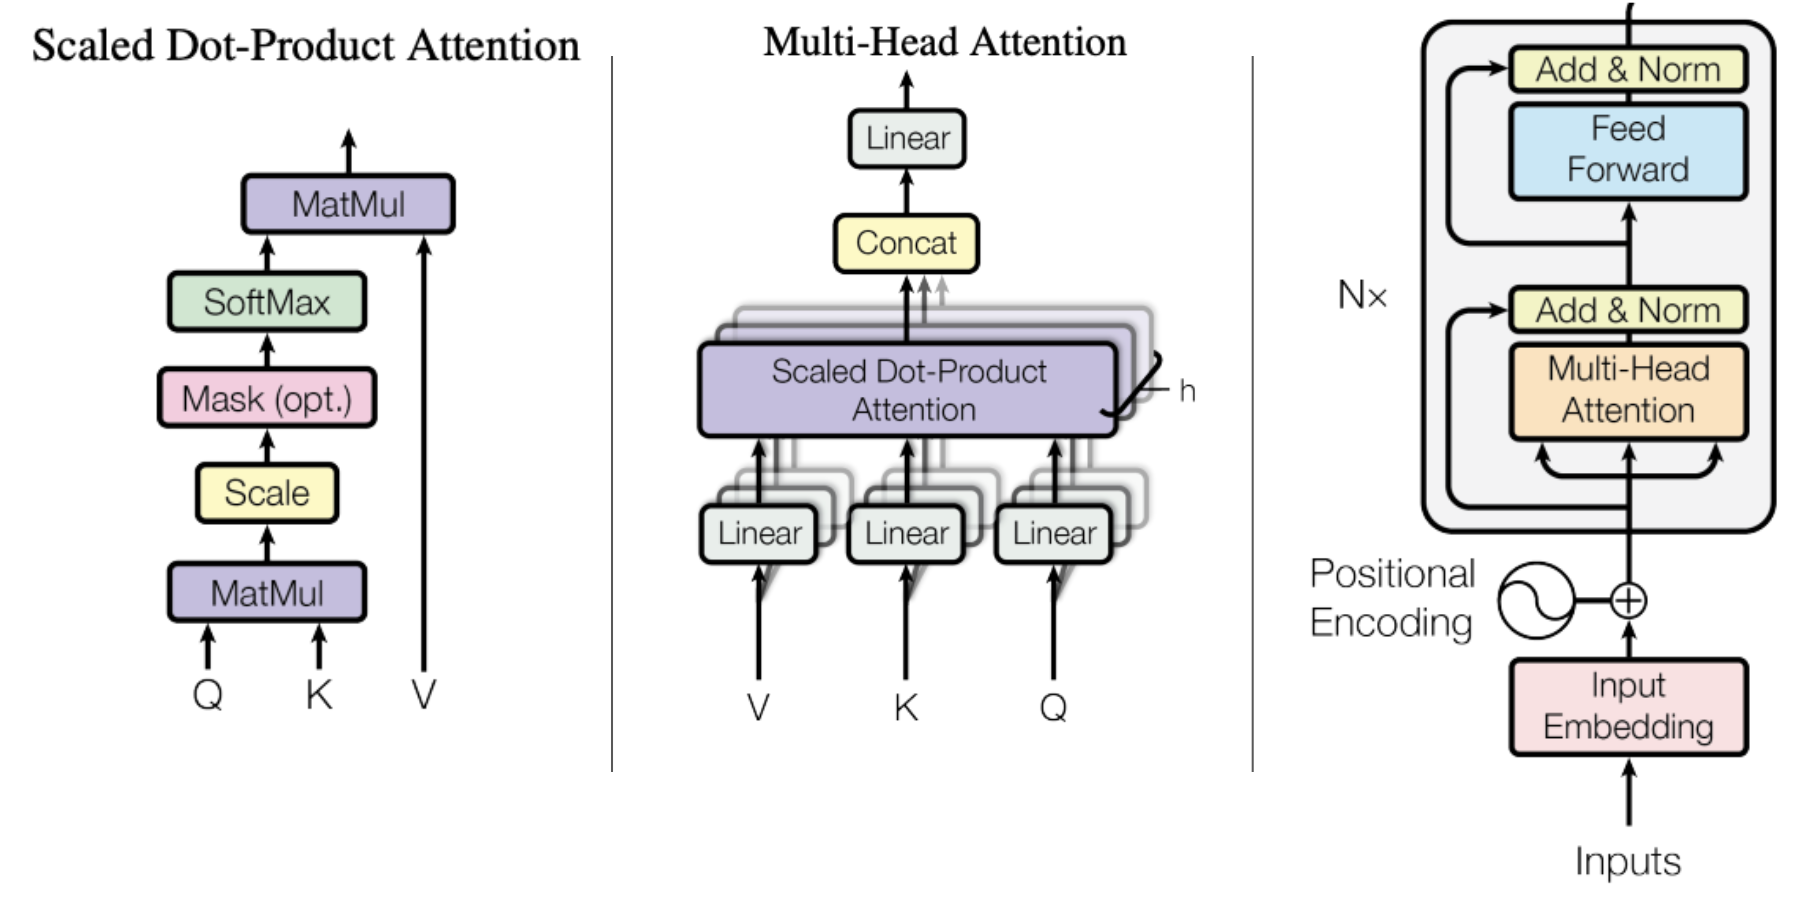

The implementation of these are all straightforward.

```python
class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Block(nn.Module):
    def __init__(
        self,
        dim: int,
        attn_target: Callable,
        mlp_ratio: int = 4,
        act_layer: Callable = nn.GELU,
        norm_layer: Callable = nn.LayerNorm,
        ffn_dropout_rate: float = 0.0,
    ):
        super().__init__()
        self.attn = attn_target()
        self.norm_1 = norm_layer(dim)
        mlp_hidden_dim = int(mlp_ratio * dim)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=ffn_dropout_rate,
        )
        self.norm_2 = norm_layer(dim)

    def forward(self, x: torch.Tensor):
        x = x + self.attn(self.norm_1(x))
        x = x + self.mlp(self.norm_2(x))
        return x
```

## FFN

The `self.mlp` is a fully connected layer which, crucially, operates independently on each token (i.e., the same weights are applied to each token in the sequence). Attention handles relationships between tokens. In Lucas Beyer's talk, he notes some folks think the MLP weights might be where "world knowledge" resides.

The main implementation detail to note is the `mlp_ratio: int = 4` which is standard practice in transformers. This means the hidden dimension of the NN is `mlp_hidden_dim = int(mlp_ratio * dim)`, e.g., for a `512`-dim transformer, we have a `2048`-dim MLP.

*Most of the weights of a transformer model are in the FFN!*

Also, see this useful overview of counting parameters in a transformer:

https://kipp.ly/transformer-param-count/

## Residual Connections

These are just the additions we see in the call to `forward`:

```python
    def forward(self, x: torch.Tensor):
        x = x + self.attn(self.norm_1(x))
        x = x + self.mlp(self.norm_2(x))
        return x
```

What could be simpler?

## LayerNorm

`self.norm_1` and `self.norm_2` are instantiated with `LayerNorm` where we are simply normalizing over the embedding dimension:

[diagram taken from this stackoverflow post](https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm)
![LayerNorm](https://i.stack.imgur.com/E3104.png)

Another picture I find useful is from the pytorch docs:

https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

<div>
<img src="https://pytorch.org/docs/stable/_images/layer_norm.jpg" width="150"/>
</div>

Instead of normalizing over the minibatch dimension ($N$), layernorm operates over the channel ($C$) and spatial dimensions ($H, W$ - mushed together in the image).


---

## A note on sequence lengths

One thing that may not immediately pop out from the above implementation is that *transformers can operate on arbitrary sequence lengths*. In other words, the sequence length is an implicit parameter of the input, not of the transformer model.

We'll briefly look at this again below, but in practice you'll probably have a fixed training sequence length, along with a position encoding which may or may not support interpolation for varying the sequence length (or context length) at inference time.


# Accelerated version of MHA
As a final aside, it is easy to replace the above implementation with torch's built-in Multi-Head Attention:

https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

Note that in their docs:
* $L$ is the sequence length - the number of tokens (denoted as $N$ in above notation)
* $E, E_q, E_k, E_v$ are all the embedding dimension (`512` in our worked example)
* $N$ in their documentation is the batch size (denoted as $B$ in the code above)

You'll need to either pass in `batch_first=True` or reorder the inputs via `einops` like so:

```python
# taken from https://github.com/facebookresearch/ImageBind/blob/main/imagebind/models/multimodal_preprocessors.py
class EinOpsRearrange(nn.Module):
    def __init__(self, rearrange_expr: str, **kwargs) -> None:
        super().__init__()
        self.rearrange_expr = rearrange_expr
        self.kwargs = kwargs

    def forward(self, x):
        assert isinstance(x, torch.Tensor)
        return einops.rearrange(x, self.rearrange_expr, **self.kwargs)

SimpleTransformer(
        embed_dim=embed_dim,
        num_blocks=num_blocks,
        ffn_dropout_rate=ffn_dropout,
        attn_target=partial(
            torch.nn.MultiheadAttention, # out-of-box from pytorch
            embed_dim=embed_dim,
            num_heads=num_heads,
            bias=True,
        ),
        pre_transformer_layer=nn.Sequential(
            nn.LayerNorm(embed_dim, eps=1e-6),
            EinOpsRearrange("b l d -> l b d"), # when using nn.MultiheadAttention batch_first=False by default (i.e., S N E == L B D)
        ),
        post_transformer_layer=EinOpsRearrange("l b d -> b l d"),
    )
```

# End-to-end example

Let's put our transformer to work! This simple example below defines a simple vision transformer (ViT) and trains it on FashionMNIST.

ViTs tokenize images by splitting them into patches, for example:

<div>
<img src="https://keras.io/img/examples/vision/image_classification_with_vision_transformer/image_classification_with_vision_transformer_15_1.png" width="150"/>
<img src="https://keras.io/img/examples/vision/image_classification_with_vision_transformer/image_classification_with_vision_transformer_15_2.png" width="150"/>
</div>


(taken from [the keras docs](https://keras.io/examples/vision/image_classification_with_vision_transformer/))



In [ ]:
from functools import partial
from typing import Callable, List, Optional, Tuple

import einops
import torch
import torch.nn as nn
import numpy as np

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
class Attention(nn.Module):
    def __init__(
            self,
            dim,
            num_heads=8,
            qkv_bias=False,
            qk_norm=False,
            attn_drop=0.,
            proj_drop=0.,
            norm_layer=nn.LayerNorm,
    ):
        #https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.q_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.k_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        q, k = self.q_norm(q), self.k_norm(k)

        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Block(nn.Module):
    def __init__(
        self,
        dim: int,
        attn_target: Callable,
        mlp_ratio: int = 4,
        act_layer: Callable = nn.GELU,
        norm_layer: Callable = nn.LayerNorm,
        ffn_dropout_rate: float = 0.0,
    ):
        """ modified from https://github.com/facebookresearch/ImageBind/blob/main/imagebind/models/transformer.py
        doesnt implement drop_path, layer_scale """
        super().__init__()

        assert not isinstance(
            attn_target, nn.Module
        ), "attn_target should be a Callable. Otherwise attn_target is shared across blocks!"
        self.attn = attn_target()
        self.norm_1 = norm_layer(dim)
        mlp_hidden_dim = int(mlp_ratio * dim)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=ffn_dropout_rate,
        )
        self.norm_2 = norm_layer(dim)

    def forward(self, x: torch.Tensor):
        x = x + self.attn(self.norm_1(x))
        x = x + self.mlp(self.norm_2(x))
        return x

_LAYER_NORM = partial(nn.LayerNorm, eps=1e-6)

class SimpleTransformer(nn.Module):
    def __init__(
        self,
        attn_target: Callable,
        embed_dim: int,
        num_blocks: int,
        block: Callable = Block,
        pre_transformer_layer: Optional[Callable] = None,
        post_transformer_layer: Optional[Callable] = None,
        norm_layer: Callable = _LAYER_NORM,
        mlp_ratio: int = 4,
        ffn_dropout_rate: float = 0.0,
        weight_init_style: str = "jax",  # possible values jax or pytorch
    ):
        """
        modified from https://github.com/facebookresearch/ImageBind/blob/main/imagebind/models/transformer.py
        supports Dropout in Attention and FFN
        """
        super().__init__()
        self.pre_transformer_layer = pre_transformer_layer

        self.blocks = nn.Sequential(
            *[
                block(
                    dim=embed_dim,
                    attn_target=attn_target,
                    mlp_ratio=mlp_ratio,
                    ffn_dropout_rate=ffn_dropout_rate,
                    norm_layer=norm_layer,
                )
                for i in range(num_blocks)
            ]
        )
        self.post_transformer_layer = post_transformer_layer
        self.weight_init_style = weight_init_style
        # finally, we need to initialize the weights of each module
        # docs: https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply
        # for every nn.Sequential block in self.blocks, apply will call the function passed in
        # see this explanation https://stackoverflow.com/a/55627686
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            if self.weight_init_style == "jax":
                # Based on MAE and official Jax ViT implementation
                torch.nn.init.xavier_uniform_(m.weight)
            elif self.weight_init_style == "pytorch":
                # PyTorch ViT uses trunc_normal_
                nn.init.trunc_normal_(m.weight, std=0.02)

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(
        self,
        tokens: torch.Tensor,
    ):
        """
        Inputs
        - tokens: data of shape N x L x D (or L x N x D depending on the attention implementation)

        Output
        - x: data of shape N x L x D (or L x N x D depending on the attention implementation)
        """
        if self.pre_transformer_layer:
            tokens = self.pre_transformer_layer(tokens)
        for blk_id, blk in enumerate(self.blocks):
            tokens = blk(tokens)
        if self.post_transformer_layer:
            tokens = self.post_transformer_layer(tokens)
        return tokens


In [ ]:
# https://github.com/facebookresearch/ImageBind/blob/main/imagebind/models/multimodal_preprocessors.py

class SelectElement(nn.Module):
    def __init__(self, index) -> None:
        super().__init__()
        self.index = index

    def forward(self, x):
        assert x.ndim >= 3
        return x[:, self.index, ...]

class PatchEmbedGeneric(nn.Module):
    """
    PatchEmbed from Hydra
    """

    def __init__(self, proj_stem, norm_layer: Optional[nn.Module] = None):
        super().__init__()

        if len(proj_stem) > 1:
            self.proj = nn.Sequential(*proj_stem)
        else:
            # Special case to be able to load pre-trained models that were
            # trained with a standard stem
            self.proj = proj_stem[0]
        self.norm_layer = norm_layer

    def get_patch_layout(self, img_size):
        with torch.no_grad():
            dummy_img = torch.zeros(
                [
                    1,
                ]
                + img_size
            )
            dummy_out = self.proj(dummy_img)
        embed_dim = dummy_out.shape[1]
        patches_layout = tuple(dummy_out.shape[2:])
        num_patches = np.prod(patches_layout)
        return patches_layout, num_patches, embed_dim

    def forward(self, x):
        x = self.proj(x)
        # B C (T) H W -> B (T)HW C
        x = x.flatten(2).transpose(1, 2)
        if self.norm_layer is not None:
            x = self.norm_layer(x)
        return x

def get_sinusoid_encoding_table(n_position, d_hid):
    """Sinusoid position encoding table"""
    def get_position_angle_vec(position):
        return [
            position / np.power(10000, 2 * (hid_j // 2) / d_hid)
            for hid_j in range(d_hid)
        ]

    sinusoid_table = np.array(
        [get_position_angle_vec(pos_i) for pos_i in range(n_position)]
    )
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)


def _get_pos_embedding(
    npatch_per_img,
    pos_embed,
    patches_layout,
    input_shape,
    first_patch_idx=1,
):

    assert first_patch_idx == 0 or first_patch_idx == 1, "there is 1 CLS token or none"
    N = pos_embed.shape[1] - first_patch_idx  # since it's 1 if cls_token exists
    if npatch_per_img == N:
        return pos_embed
    raise ValueError("position interpolation not supported")

class SpatioTemporalPosEmbeddingHelper(nn.Module):
    def __init__(
        self,
        patches_layout: List,
        num_patches: int,
        num_cls_tokens: int,
        embed_dim: int,
        learnable: bool,
    ) -> None:
        super().__init__()
        self.num_cls_tokens = num_cls_tokens
        self.patches_layout = patches_layout
        self.num_patches = num_patches
        self.num_tokens = num_cls_tokens + num_patches
        self.learnable = learnable
        if self.learnable:
            self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, embed_dim))
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
        else:
            self.register_buffer(
                "pos_embed", get_sinusoid_encoding_table(self.num_tokens, embed_dim)
            )

    def get_pos_embedding(self, vision_input, all_vision_tokens):
        input_shape = vision_input.shape
        pos_embed = _get_pos_embedding(
            all_vision_tokens.size(1) - self.num_cls_tokens,
            pos_embed=self.pos_embed,
            patches_layout=self.patches_layout,
            input_shape=input_shape,
            first_patch_idx=self.num_cls_tokens,
        )
        return pos_embed


class ImagePreprocessor(nn.Module):
    def __init__(
        self,
        stem: PatchEmbedGeneric,
        img_size: Tuple = (3, 224, 224),
        num_cls_tokens: int = 1,
        pos_embed_fn: Optional[Callable] = None,
        init_param_style: str = "openclip",
    ) -> None:
        super().__init__()
        (
            self.patches_layout,
            self.num_patches,
            self.embed_dim,
        ) = stem.get_patch_layout(img_size)
        self.stem = stem
        self.use_pos_embed = pos_embed_fn is not None
        self.num_cls_tokens = num_cls_tokens

        if self.use_pos_embed:
            self.pos_embedding_helper = pos_embed_fn(
                patches_layout=self.patches_layout,
                num_cls_tokens=num_cls_tokens,
                num_patches=self.num_patches,
                embed_dim=self.embed_dim,
            )
        if self.num_cls_tokens > 0:
            self.cls_token = nn.Parameter(
                torch.zeros(1, self.num_cls_tokens, self.embed_dim)
            )

        self.init_parameters(init_param_style)

    @torch.no_grad()
    def init_parameters(self, init_param_style):
        if init_param_style == "openclip":
            # OpenCLIP style initialization
            scale = self.embed_dim**-0.5
            if self.use_pos_embed:
                nn.init.normal_(self.pos_embedding_helper.pos_embed)
                self.pos_embedding_helper.pos_embed *= scale

            if self.num_cls_tokens > 0:
                nn.init.normal_(self.cls_token)
                self.cls_token *= scale
        elif init_param_style == "vit":
            self.cls_token.data.fill_(0)
        else:
            raise ValueError(f"Unknown init {init_param_style}")


    def tokenize_input_and_cls_pos(self, input, stem):
        # tokens is of shape B x L x D
        tokens = stem(input)
        assert tokens.ndim == 3
        assert tokens.shape[2] == self.embed_dim
        B = tokens.shape[0]
        if self.num_cls_tokens > 0:
            class_tokens = self.cls_token.expand(
                B, -1, -1
            )  # stole class_tokens impl from Phil Wang, thanks
            tokens = torch.cat((class_tokens, tokens), dim=1)
        if self.use_pos_embed:
            pos_embed = self.pos_embedding_helper.get_pos_embedding(input, tokens)
            tokens = tokens + pos_embed
        return tokens

    def forward(self, vision):
        vision_tokens = self.tokenize_input_and_cls_pos(
            vision, self.stem
        )
        return vision_tokens

In [ ]:
class VisionModel(nn.Module):
    def __init__(
        self,
        num_classes,
        img_size=[1, 96, 96],
        kernel_size=(16,16),
        embed_dim=16,
        num_blocks=4,
        num_heads=4,
        attn_dropout=0.0,
        ffn_dropout=0.0,
        learn_pos_embed=True,
    ):
        super().__init__()

        stem = PatchEmbedGeneric(
            proj_stem=[
                nn.Conv2d(
                    in_channels=1,
                    kernel_size=kernel_size,
                    stride=kernel_size,
                    out_channels=embed_dim,
                    bias=False,
                ),
            ],
            norm_layer=nn.LayerNorm(normalized_shape=embed_dim),
        )

        self.preprocessor = ImagePreprocessor(
            img_size=img_size,
            num_cls_tokens=1,
            pos_embed_fn=partial(SpatioTemporalPosEmbeddingHelper, learnable=learn_pos_embed),
            stem=stem,
        )

        self.transformer = SimpleTransformer(
                embed_dim=embed_dim,
                num_blocks=num_blocks,
                ffn_dropout_rate=ffn_dropout,
                attn_target=partial(
                    Attention,
                    dim=embed_dim,
                    num_heads=num_heads,
                    qkv_bias=True,
                    attn_drop=attn_dropout,
                ),
                pre_transformer_layer=nn.Sequential(
                    nn.LayerNorm(embed_dim, eps=1e-6),
                ),
            )

        self.head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6),
            SelectElement(index=0),
            nn.Linear(embed_dim, num_classes, bias=False),
        )

    def forward(self, x):
        x = self.preprocessor(x)
        x = self.transformer(x)
        x = self.head(x)
        return x


The FashionMNIST example below is taken from the quickstart pytorch tutorial:

https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#optimizing-model-parameters

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.Resize(96), transforms.ToTensor()])
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.Resize(96), transforms.ToTensor()])
)

In [ ]:
import matplotlib.pyplot as plt
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Now let's check the dimensions of the transformer's inputs and outputs.

For an input grayscale (1-channel) image of 96x96 pixels, and a kernel size of 16x16, we should expect a patch layout of 6 patches x 6 patches, as  $ 6 = 96 / 16$

We will thus have 36 ($=6 \times 6$) image patches altogether, but we also prepend a zero (or randomly) initialized, learnable <u>class token</u> for classification, bringing the total number of tokens to 37

```python
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
        ...
        # duplicate the tokens across the full batch:
        class_tokens = self.cls_token.expand(B, -1, -1)
        tokens = torch.cat((class_tokens, tokens), dim=1)
```

In [ ]:
# instantiate a model
m = VisionModel(num_classes=10, img_size=[1, 96, 96], kernel_size=(16,16), embed_dim=512, num_blocks=2, num_heads=8)

# run 10 random images through the untrained model
x = torch.rand(10,1,96,96)
out = m(x)

print(m.preprocessor.stem.get_patch_layout(img_size=[1, 96, 96]))
# ((6, 6), 36, 512)

# the output is logits, like any classification network: (batch_size, num_classes)
print(out.shape)
# torch.Size([10, 10])

# (batch_size, num_tokens, embedding_dimension)
print(m.preprocessor(x).shape)
# torch.Size([10, 37, 512])

print(m.transformer.blocks[0])

```python
print(m.transformer.blocks[0])
```

```
Block(
  (attn): Attention(
    (qkv): Linear(in_features=512, out_features=1536, bias=True)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=512, out_features=512, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (norm_1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=512, out_features=2048, bias=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=2048, out_features=512, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
  )
  (norm_2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
)
```

As noted above, the transformer does <u>not</u> depend on the number of tokens! That is an implicit dimension in the input, and this is what allows for variable-context-size (or variable-resolution) transformers, via position interpolation.

See https://github.com/lucidrains/rotary-embedding-torch for an example of a current (as of Sept 2023) approach to position interpoloation.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

model = VisionModel(num_classes=10, embed_dim=512, num_blocks=2, num_heads=8, attn_dropout=0.1, ffn_dropout=0.5, learn_pos_embed=False)
model.to(device)
learning_rate = 1e-3
batch_size = 64
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")